## Food Inspection Analysis

### Potential Features  

The initial plan is to consider these features.  The basic data cleaning was performed in the `feature_extraction.ipynb` notebook.  The data being pulled into this notebook is the combination of the City of Chicago Food Inspection and Business License dataset.  These datasets were combined to fill in some of the missing values and add a few features.  In the future, additional information will be added to further fill in missing data and to add features like cuisine type and number of Starbucks within a certain distance.   

1.  name  
1.  license number  
1.  result (pass/fail) \<target>
1.  business age (default start from 2010 inspection date)  
1.  number of chains / is_chain boolean 
1.  risk  
1.  ward / neighborhood
1.  license code  
1.  renew  
1.  conditional approved  
1.  business activity
1.  *number of (pass/fail) inspections during 1st, 2nd, 3rd, and 4th most recent license period
    * this can have errors so maybe use years from year_min to simplify

*This will be a feature added in the future

In [9]:
# Import required libraries

# # Code formatter
# # !pip3 install nb_black
# %load_ext nb_black

# eda tools
import numpy as np
import math
import pandas as pd
import re

# visualization dependencies
import matplotlib.pyplot as plt  
import seaborn as sns

# hide jupyter lab warnings
import warnings
warnings.filterwarnings('ignore')

# expand the number of dataframe columns visible
pd.options.display.max_columns = 100

# make sound when this code executes: Audio(sound_file, autoplay=True)
from IPython.display import Audio
sound_file = './sound/chord.wav'

# display package informatin
# !conda install -c conda-forge session-info
import session_info
session_info.show()

### Read Dataset

In [10]:
# Read data
restaurant_df = pd.read_csv('./data/manipulated/combined_data.csv', parse_dates=['inspect_date', 'approx_start_date'])
# restaurant_df['week'] = restaurant_df['inspect_date'].dt.week  
restaurant_df.rename(columns={'Unnamed: 0':'original_index'}, inplace=True)
restaurant_df.head()

,original_index,inspect_id,aka_name_x,license_num,facility_type,risk,address_x,city,state,zipcode,inspect_date,inspect_type,results,violations,lat,lon,violations_list,violation_count,violation_number,vl_must_comply_list,vl_must_comply_count,vl_instructed_comply_list,vl_instructed_comply_count,vl_not_cited_list,vl_citation_count,year,month,aka_name_y,license_id,address_y,ward,precint,police_district,license_code,license_description,bus_activity_id,bus_activity,application_type,conditional_approval,approx_start_date,year_min,year_max,bus_age,license_alias,number_of_chains,week,inspections_per_year,type_of_restaurant
0,3,2579789,SENOR PAN CAFE,2659113.0,Restaurant,Risk 1 (High),4612 W FULLERTON AVE,CHICAGO,IL,60639.0,2023-08-09,Canvass Re-Inspection,Pass,-99. No violations reported,41.924402,-87.742318,['-99. No violations reported'],1,['99'],[False],0,[False],0,[False],1,2023,8,SENOR PAN CAFE,2899694.0,4612 W FULLERTON AVE 1,31.0,29.0,25.0,1006.0,Retail Food Establishment,735,Preparation of Food and Dining on Premise With...,RENEW,N,2023-05-16,2019.0,2023.0,4.0,14065,5,32,12,2-5 Sites
1,4,2579779,TAQUERIA CD HIDALGO,2078867.0,Restaurant,Risk 1 (High),7104 N CLARK ST,CHICAGO,IL,60626.0,2023-08-08,Canvass,Pass,-99. No violations reported,42.011581,-87.674614,['-99. No violations reported'],1,['99'],[False],0,[False],0,[False],1,2023,8,TAQUERIA CD HIDALGO,2884398.0,7104 N CLARK ST 1ST,49.0,3.0,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,RENEW,N,2023-02-16,2011.0,2023.0,12.0,15894,1,32,24,Single Site
2,7,2579723,BAR COCINA,2334704.0,Restaurant,Risk 1 (High),2901 N SHEFFIELD AVE,CHICAGO,IL,60657.0,2023-08-08,Canvass Re-Inspection,Pass,-99. No violations reported,41.934501,-87.653775,['-99. No violations reported'],1,['99'],[False],0,[False],0,[False],1,2023,8,BAR COCINA,2898722.0,2901 N SHEFFIELD AVE 1,44.0,29.0,19.0,1006.0,Retail Food Establishment,735,Preparation of Food and Dining on Premise With...,RENEW,N,2023-05-16,2015.0,2023.0,8.0,1121,1,32,17,Single Site
3,8,2579643,Itoko / GG'S Chicken Shop / Little Goat Diner,2872999.0,Restaurant,Risk 1 (High),3323-3325 N SOUTHPORT AVE,CHICAGO,IL,60657.0,2023-08-07,Complaint Re-Inspection,Pass,-99. No violations reported,41.942334,-87.663739,['-99. No violations reported'],1,['99'],[False],0,[False],0,[False],1,2023,8,Itoko / GG's Chicken Shop / Little Goat Diner,2872999.0,3323-3325 N SOUTHPORT AVE LL-2,44.0,NaN,NaN,1006.0,Retail Food Establishment,735,Preparation of Food and Dining on Premise With...,ISSUE,Y,2023-02-21,2023.0,2023.0,0.0,7640,1,32,6,Single Site
4,10,2579561,JIN JU,27137.0,Restaurant,Risk 1 (High),5203 N CLARK ST,CHICAGO,IL,60640.0,2023-08-04,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.976301,-87.668276,['10. ADEQUATE HANDWASHING SINKS PROPERLY SUPP...,4,"['10', '47', '55', '58']","[False, False, False, False]",0,"[False, False, False, False]",0,"[False, False, False, False]",4,2023,8,JIN JU,2907977.0,5203 N CLARK ST 1ST,48.0,10.0,20.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,RENEW,N,2023-07-16,2001.0,2023.0,22.0,8059,1,31,19,Single Site


### Create Summary Statistics  
- in place of number of fail, I will often use percent fail  

**Checks**  
1 - Categorical plot of X (# starbucks) with pass/fail color coding   
1 - Bar chart of X (# starbucks) with pass/fail bars    
1 - Line chart of Fail Percent versus # of starbucks  
2/3 - Similar to above  
4/5 - not applicable but used to derive other features  

6/7/8/9 - Does time affect events?  How does the total/percent of fails change over time?  Are there more fails during a particular season?   Start with overall macro effects.  Are there multiple inspections for the same day for the same license number?  May need to combine.   

** To do micro (comapny or license scale) the first need to answer these questions:  
Is the company and address the same but different license number? May need to drop one of the license numbers.   
What is the relation between previous number of inspections and success? - maybe show a category chart of 1st inspection (red is fail, blue is pass) through 10th inspection.  

10 - line chart versus percent fail  
11 - bar chart of franchise size  
11 - line chart of franchise size versus percent fail  
12 - bar chart comparing is chain and is not chain  
12 - bar chart comparing percent fail of chain versus not chain  
13 - bar chart comparing 3 risk categories and percent fail  
14 - bar chart of wards and percent fail  
14 - Does the location make a difference?  Make a bar chart.  
14 (other) - Do certain addresses with multiple companies have a history of failing?   
15 - license code - not needed  
16 - bar chart of renew and percent fail  
16 - bar chart of renew count verus first inspection count  
17 - bar chart of condiational approval  boolean and percent fail  
18 - bar chart of total count fails per business and bar chart of percent fail per business  
19 - active or inactive business (based on business license experation)

- Is there a pair plot with bars in the background?  

## Analysis

### Data Consistency Checks

In [11]:
# Did the merge work appropriately?  Check the addresses - it is more specific than name.  
# shows that the two address look like they largely line up for the 148k records - 2500 records have mismatches but due to abbreviations and spacing differences
x = restaurant_df['address_x'].apply(lambda x: x[0:10].lower())
y = restaurant_df['address_y'].apply(lambda x: x[0:10].lower())

restaurant_df[ x != y][['aka_name_x','address_x', 'aka_name_y','address_y']]

,aka_name_x,address_x,aka_name_y,address_y
15,BURGER KING #11967,2401-2407 W OGDEN AVE,BURGER KING #11967,2401-07 W OGDEN AVE
71,MARISCOS EL PUERTO,3016-3018 W 47th ST,EL PUERTO RESTAURANT,3016 - 3018 W 47TH ST 1ST
133,OLD PUEBLO CANTINA,1200-02 W WEBSTER AVE,Old Pueblo Cantina,1200-1202 W WEBSTER AVE 1
238,TRUE FOOD KITCHEN,9 W ERIE ST,TRUE FOOD KITCHEN,1-9 W ERIE ST 1ST
282,CAMPUS CENTER CAFE,37-39 S WABASH AVE,Campus Center Cafe,37 - 39 S WABASH AVE 2
...,...,...,...,...
147582,jai hind vegetarian restaurant,6410-12 N CLAREMONT AVE,JAIHIND RESTAURANT,6410 N CLAREMONT AVE
147589,LA VILLA,3632 N PULASKI RD,LA VILLA,3632-3640 N PULASKI RD
147615,CHINA KING BUFFET,4616-4618 W DIVERSEY AVE,CHINA KING BUFFET,4616 - 4618 W DIVERSEY AVE 1
147658,TRU,676 N ST CLAIR ST,RAMEN-SAN DELUXE / TALL BOY TACO,165 E HURON ST 1ST SP1


In [12]:
# show that for every name and address, there is a unique license_alias id number
# this removes confusion for restaurants with the same name and address that have multiple licenses
# information about the license is not lost since the original license_num is kept but also there are identifying columns like violations, license type, and license code that provide clarity

temp2 = restaurant_df.groupby(['aka_name_x','address_x']).count()['risk']
print('Unique Name/Addresses Combos ', len(temp2))

temp = restaurant_df.groupby(['aka_name_x','address_x','license_alias']).count()['risk']
print('Number of License Alias: ', len(temp))

print('Number of License Alias Confirmed: ', restaurant_df['license_alias'].nunique())


Unique Name/Addresses Combos  18372
Number of License Alias:  18372
Number of License Alias Confirmed:  18372


In [13]:
# Are there multiple inspections for the same day for the same license number? 
# Yes, removed the rows that were identical (added code to feature_extraction.ipynb)
# remaining duplicates are from failed initial attempt and later in the day fix and reinspect

# view inspection date and license number for duplicate records
restaurant_df.groupby(['inspect_date','license_num', 'aka_name_x']).count()['inspect_id'].sort_values(ascending=False)

# # review an example where multiple inspections occured on the same day
# restaurant_df[restaurant_df['aka_name_x'] == "PETE'S  PIZZA & BAKEHOUSE"].loc[:,['aka_name_x','license_num','facility_type','risk','address_x','city','state','zipcode',
#                                                                                'inspect_date','inspect_type','results','violations','lat','lon', 'year']].sort_values(by='inspect_date')

inspect_date  license_num  aka_name_x                  
2010-08-30    1168722.0    El Senor Sombrero               2
2015-09-22    2359797.0    BUFFALO WILD WINGS              2
2010-05-20    40155.0      POPEYES CHICKEN/INDIAN SWAAD    2
2018-04-17    2589600.0    BARWAQO KABOB ONE               2
2016-03-04    2379022.0    L C PHO RESTAURANT              2
                                                          ..
2014-07-17    2262795.0    FREDDIES                        1
              2269544.0    DOMINO'S PIZZA                  1
              2278208.0    HALSTED STREET DELI             1
              2293872.0    JA GRILL HYDE PARK              1
2023-08-11    2868123.0    Hale McDonald's                 1
Name: inspect_id, Length: 147785, dtype: int64

In [6]:
# Is the company name and address unique for each license number?
# No, some locations have one license number for multiple restaurant names.  Below are several variations of this question.   



# # Museum Campus example (license_num 1354323)  - shows multiple restaurants under the same address and license_num
# temp = restaurant_df.groupby(['aka_name_x','address_x','license_num']).size().reset_index()
# temp.groupby('license_num').count().sort_values(by='aka_name_x', ascending=False)['aka_name_x']
# restaurant_df[restaurant_df['license_num'] == 1354323]  
# # Alternate way of finding all the cases 
# temp = restaurant_df.groupby(['aka_name_x','address_x', 'license_num']).size().reset_index()
# temp.groupby(['address_x', 'license_num']).count().sort_values(by=0, ascending=False)
# restaurant_df[(restaurant_df['address_x'] == '1410 S MUSEUM CAMPUS DR') & (restaurant_df['license_num'] == 1354323.0)].sort_values(by='address_x') 

# # Chop Suey example - shows multiple license_num having the same restaurant name and address 
# temp = restaurant_df.groupby(['aka_name_x', 'address_x', 'license_num']).count()[['risk', 'inspect_date']]  
# temp.xs('#1 CHOP SUEY', level='aka_name_x')

# # Lucky Strike - shows multiple address having the same license_num and business name 
# temp = restaurant_df.groupby(['aka_name_x', 'license_num', 'address_x']).size().reset_index()
# temp.groupby(['aka_name_x', 'license_num']).count().sort_values(by=0, ascending=False)  
# restaurant_df[restaurant_df['aka_name_x'] == 'LUCKY STRIKE']


# # the combination of multiple store at the same address with multiple licenses is just a combo store and is normal like Long John Silvers and A&W Rootbeer or a food court  
# # here is an example with a Medical Center Food Court
# restaurant_df[restaurant_df['aka_name_x'] == 'PRESENCE RESURRECTION MEDICAL CENTER']  
# # Same address but different license numbers and names could also be just different years where a restaurant changes location/closes and a new one replaces it at that location
# temp = restaurant_df.groupby(['aka_name_x', 'license_num', 'address_x']).count()['inspect_id']
# temp.xs('1 E JACKSON BLVD', level='address_x')

# # shows same business name and address with different license_num - O'Hare Airport Food Vendors
# temp = restaurant_df.groupby(['aka_name_x', 'license_num', 'address_x']).size().reset_index()
# temp.groupby('address_x').count().sort_values(by='aka_name_x', ascending=False)  
# restaurant_df[restaurant_df['address_x'] == '11601 W TOUHY AVE'].sort_values(by='license_num', ascending=False)  

# Some business names with the same address but different license_num could be due to the license code being different.  


# Solution:  
# make everything easier due to this issue, I have each business name and address a unique id called 'license_alias'.  The code for this is found in 'feature_extraction.ipynb'  






# 6/7/8/9 - Does time affect events?  How does the total/percent of fails change over time?  
# Are there more fails during a particular season?   Start with overall macro effects.  
# Are there multiple inspections for the same day for the same license number?  May need to combine.   

In [14]:
# count the number of business_activity per business
temp = restaurant_df.groupby(['license_alias', 'bus_activity']).count()['original_index'].reset_index()
temp[temp.duplicated(subset=['license_alias'], keep=False)].sort_values(by='original_index', ascending=False)

,license_alias,bus_activity,original_index
9391,7626,Retail Sales of Perishable Foods,46
12795,10438,Retail Sales of Perishable Foods,45
5244,4241,Retail Sales of Perishable Foods,38
3801,3068,Retail Sales of Perishable Foods,37
2713,2176,Retail Sales of Perishable Foods,35
...,...,...,...
15687,12832,Catering of Liquor To Events,1
15688,12832,Consumption of Liquor on Premises,1
15689,12832,Preparation of Food and Dining on Premise With...,1
5486,4444,Tavern - Consumption of Liquor on Premise,1


### Other Possible improvements

* split business_activity into:  perishable foods, onsite-prep-dining, onsite-prep-nodining,  


    * 'Preparation of Food and Dining on Premise With Seating' => food_prep_onsite_seating  / food_prep_onsite_noseating  

    * 'Sale of Food Prepared Onsite With Dining Area' / 'Sale of Food Prepared Onsite Without Dining Area' => onsite_food_prep_wDining  

    * 'Retail Sales of Perishable Foods' => perishable_food / nonperishable_food  

    * 'Consumption of Liquor on Premises' => liquor_served  


### Target Analysis (Failed/Passed Inspections )

<Axes: title={'center': 'Percent of Inspections Failed Per Year'}, xlabel='year'>

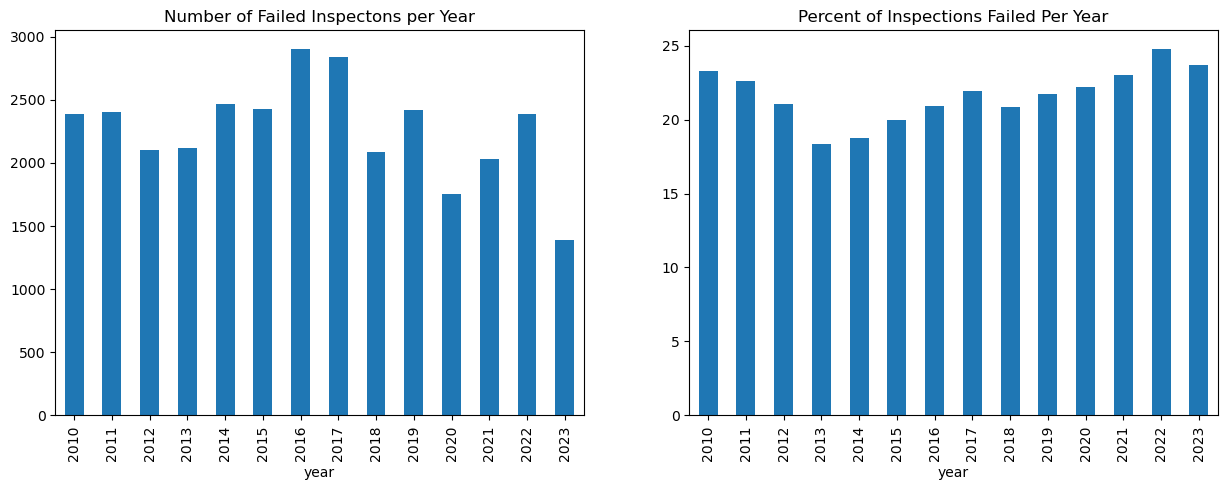

In [15]:
total_records = restaurant_df.groupby('year').count()['inspect_id']
failed_records = restaurant_df[restaurant_df['results'] == 'Fail'].groupby('year').count()['inspect_id']
failed_percent = failed_records/total_records*100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
failed_records.plot.bar(ax=axes[0], title="Number of Failed Inspectons per Year")
failed_percent.plot.bar(ax=axes[1], title="Percent of Inspections Failed Per Year")

**Review**  
Percent is probably the more stable metric.  The year-to-year variation seems high when looking at the counts but percent failure is much more consistent from year-to-year.  It is a bit odd that the failure rate has steadily increased each year from 2013 after a dramatic fall off.

<Axes: title={'center': 'Percent of Failed Inspections'}, xlabel='year,month'>

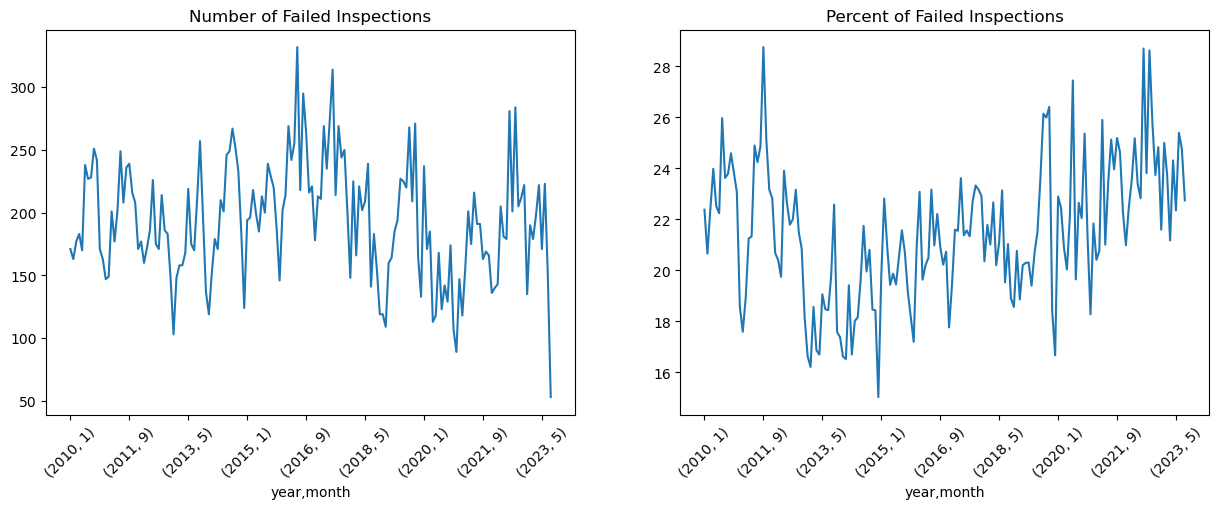

In [16]:
failed_records = restaurant_df[restaurant_df['results'] == 'Fail'].groupby(['year','month']).count()['inspect_id']
total_records = restaurant_df.groupby(['year','month']).count()['inspect_id']
failed_records_percent = failed_records/total_records*100  

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
failed_records.plot(ax=axes[0], title='Number of Failed Inspections', rot=45)
failed_records_percent.plot(ax=axes[1], title='Percent of Failed Inspections', rot=45)

**Analysis**  
The purpose of looking at this is to see if the data needs transformed so variations in time do not influence any model predictions.  
Time dependencies can be addressed by adding time components into the model (ie month, year, etc) or determining if features also have correlated time dependencies that can help incorporate the time dependency in the model.  
Other methods include using time series models (ie ARIMA, LSTM, Prophet, etc) or seasonal decomposition of time series.  

It looks like there is some cyclic nature to the output.  


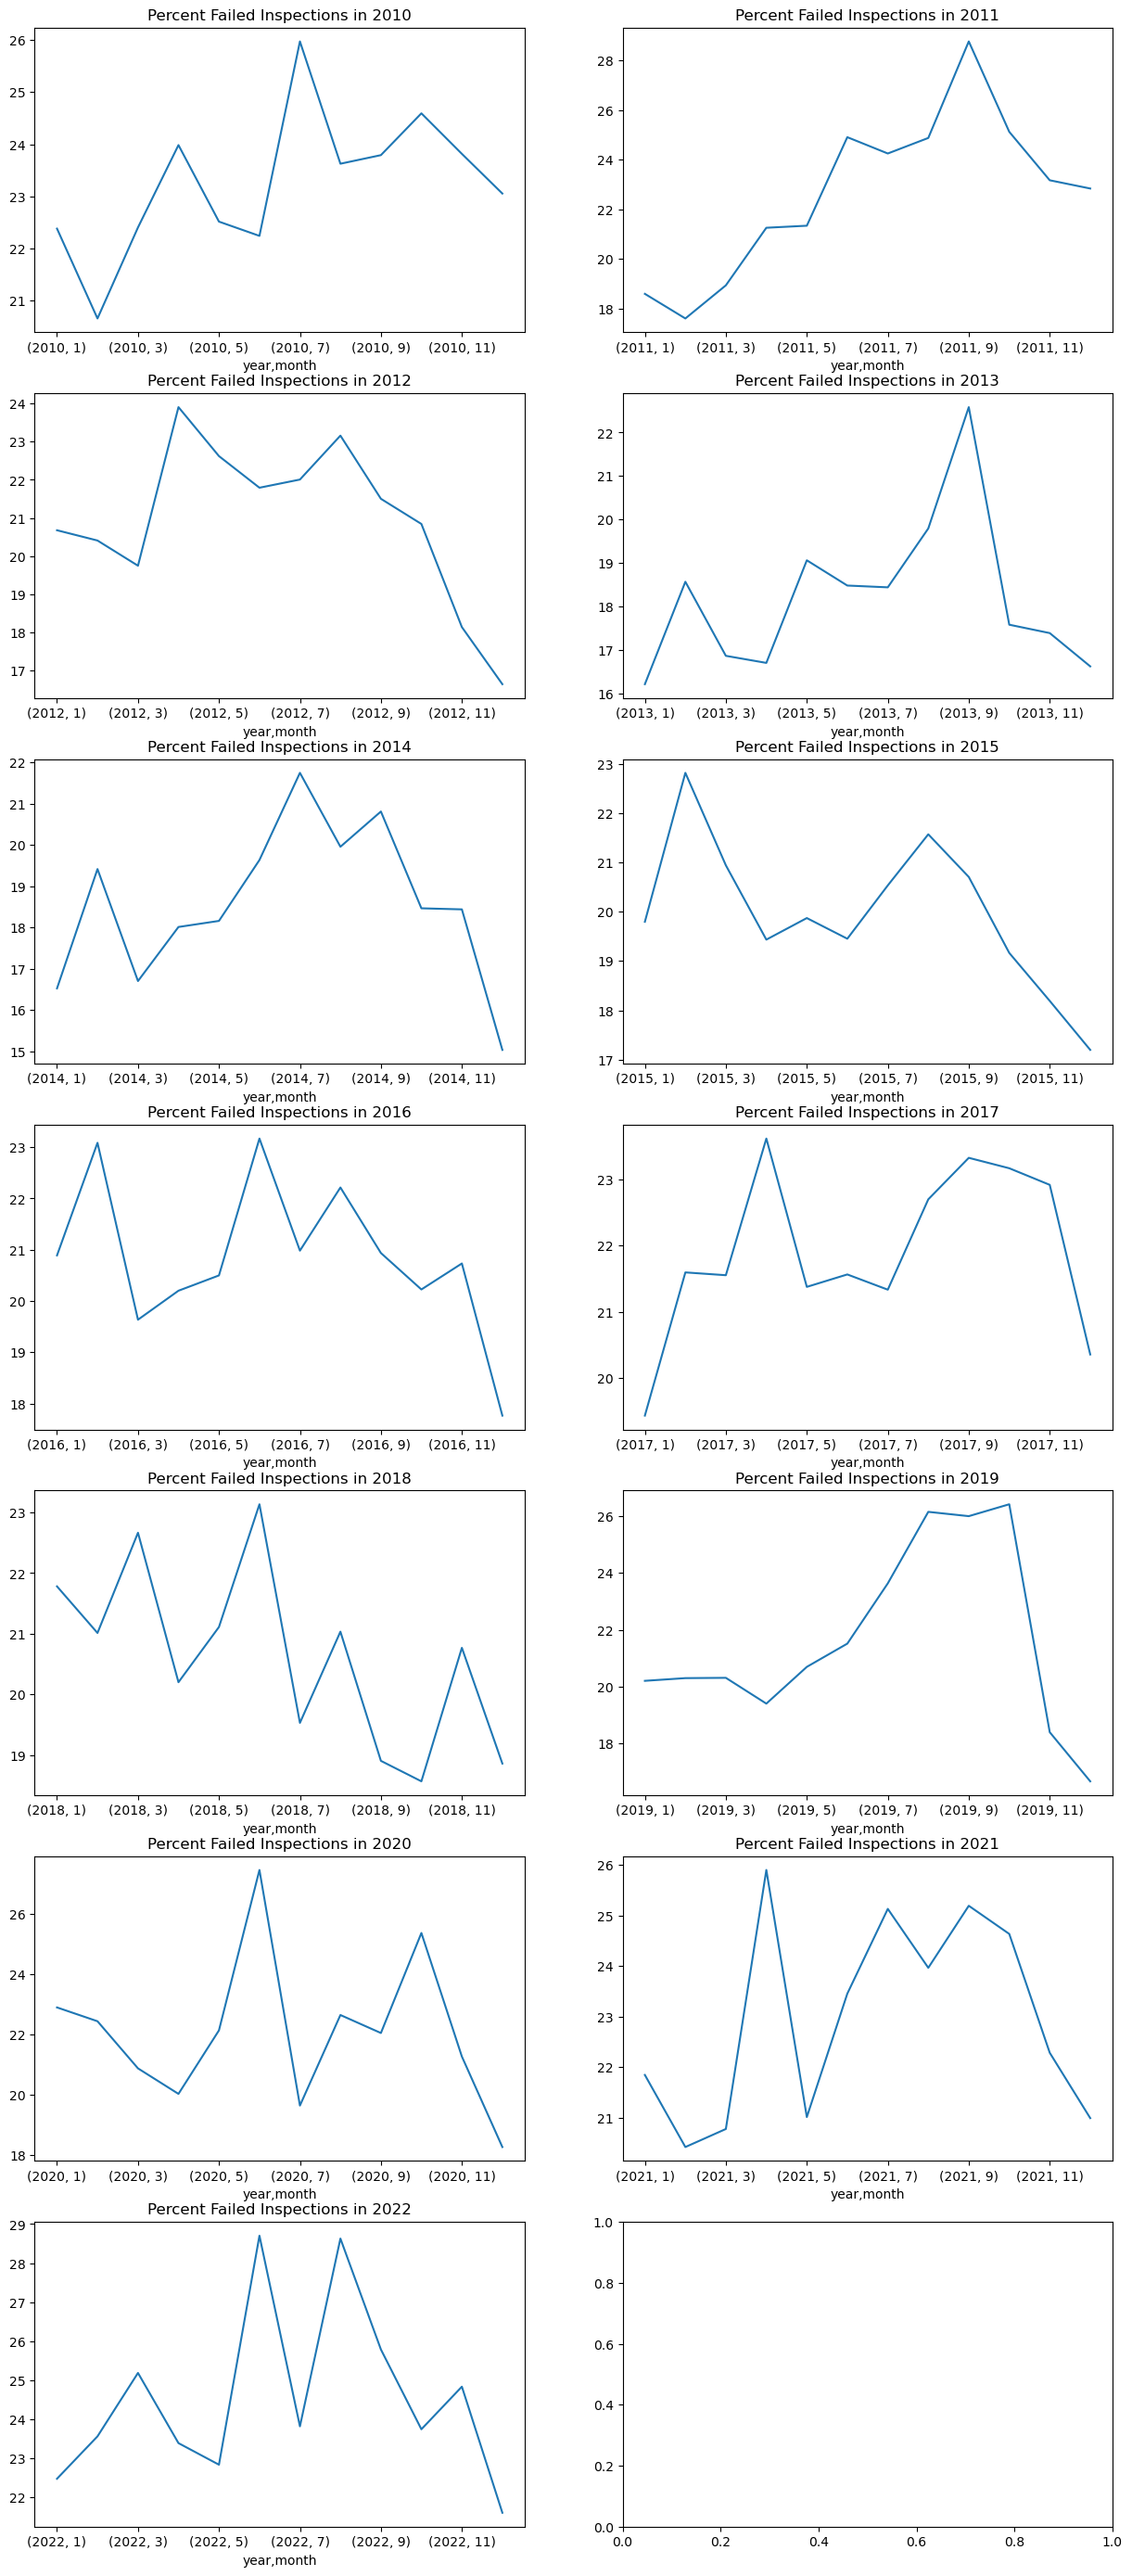

In [17]:
years = np.arange(2010, 2023, 1)
fig, axes = plt.subplots(nrows=int(math.floor(len(years)+1)/2), ncols=2, figsize=(15,35))

for index, year in enumerate(years):
    failed_records = restaurant_df[(restaurant_df['results'] == 'Fail') & (restaurant_df['year'] == year)].groupby(['year','month']).count()['inspect_id']
    total_records = restaurant_df[(restaurant_df['year'] == year)].groupby(['year','month']).count()['inspect_id']
    percent_failed = failed_records/total_records*100
    percent_failed.plot(ax=axes[int((index - index%2)/2),index%2 ], title=f"Percent Failed Inspections in {year}")

**Review**  
There seems to be some general patterns.  I chose percent failures due to the previous analysis of the year-to-year.  It looks like the summer has more reviews and failures than other times of the year.  Overall, the percent change (max/min range) is only 6-7% so that is fairly consistent.  Maybe some noise can be removed from this due to cyclic nature but not much.  

<Axes: title={'center': 'Failed inspections per month'}, xlabel='month'>

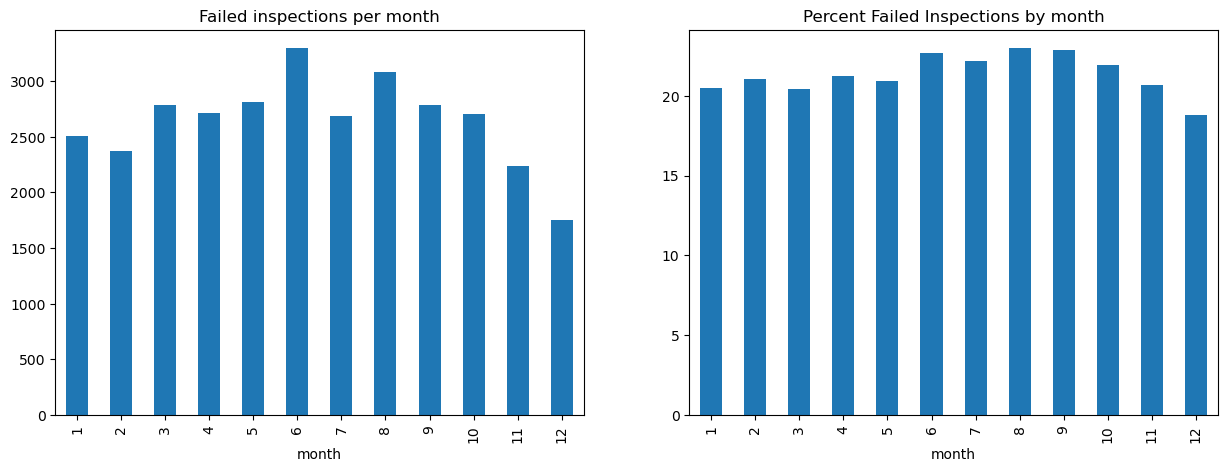

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
failed_records = restaurant_df[(restaurant_df['results'] == 'Fail')].groupby(['month']).count()['inspect_id']
total_records = restaurant_df.groupby(['month']).count()['inspect_id']
percent_failed = failed_records/total_records*100
percent_failed.plot.bar(ax=axes[1], title=f"Percent Failed Inspections by month")
failed_records.plot.bar(ax=axes[0], title="Failed inspections per month")

(0.0, 30.0)

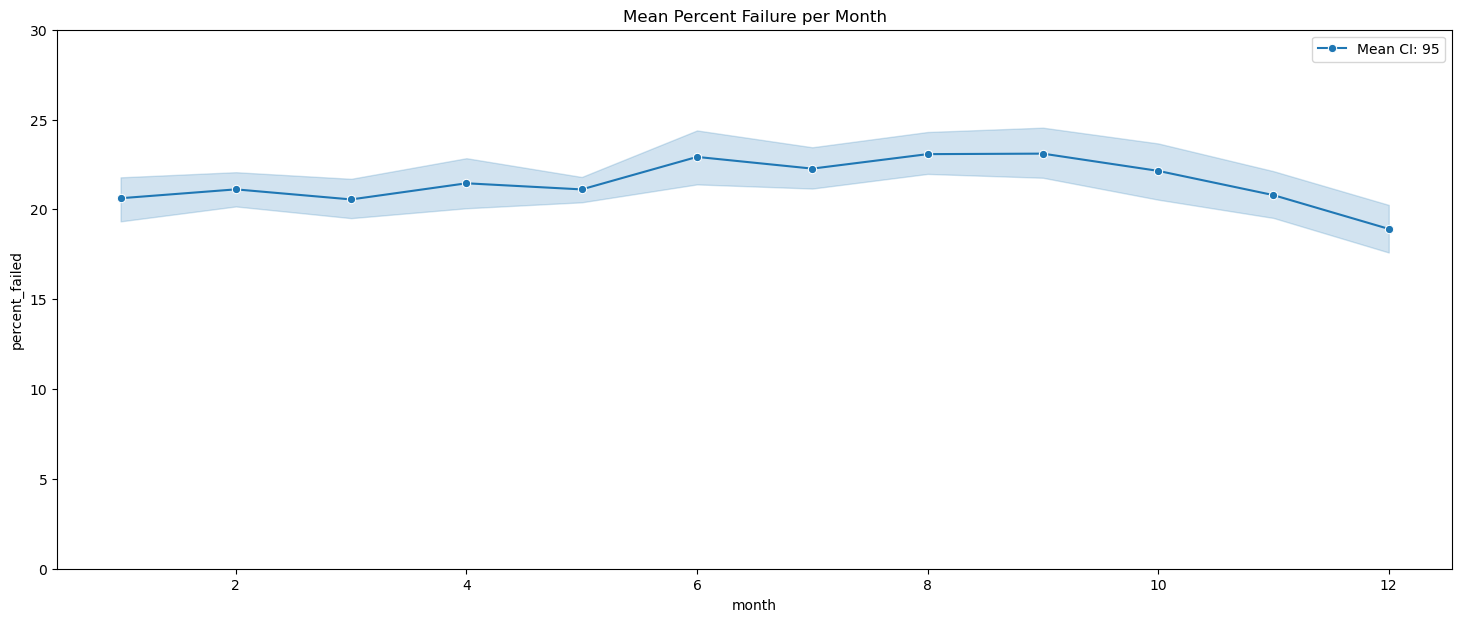

In [19]:

failed = restaurant_df[(restaurant_df['results'] == 'Fail')].groupby(['year', 'month']).count()['inspect_id']
total = restaurant_df.groupby(['year', 'month']).count()['inspect_id']
temp = failed/total*100
temp_percent = temp.reset_index().rename(columns={'inspect_id':'percent_failed'})

fig, ax = plt.subplots(ncols=1, figsize=(18, 7))
sns.lineplot(data=temp_percent, x='month', y='percent_failed', marker='o', ci=95, ax=ax, label='Mean CI: 95')
ax.set(title='Mean Percent Failure per Month')
ax.set_ylim([0, 30])

This indicates that June and August have the highest number of failed inspections.  It looks like as the number of inspections go up then the likelihood of failing inspection also goes up but using percent failed has a much lower variation.  It is probably not necessary  
** Change to line plots and add error bars

<Axes: title={'center': 'Failed inspections per week'}, xlabel='week'>

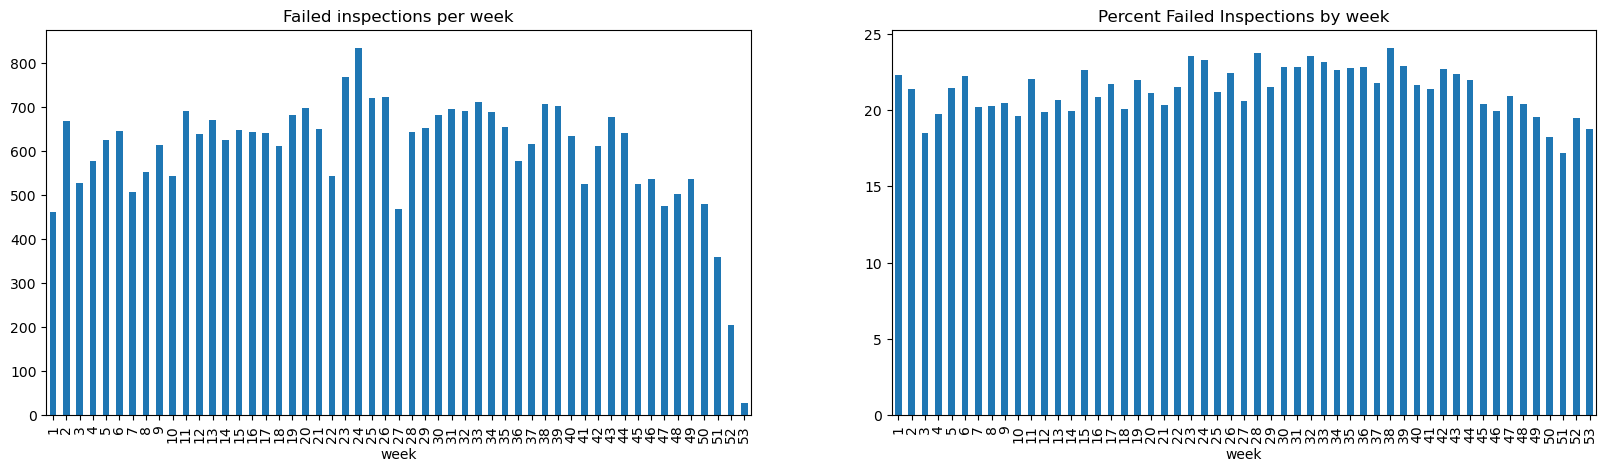

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
failed_records = restaurant_df[(restaurant_df['results'] == 'Fail')].groupby(['week']).count()['inspect_id']
total_records = restaurant_df.groupby(['week']).count()['inspect_id']
percent_failed = failed_records/total_records*100
percent_failed.plot.bar(ax=axes[1], title=f"Percent Failed Inspections by week")
failed_records.plot.bar(ax=axes[0], title="Failed inspections per week")

(0.0, 30.0)

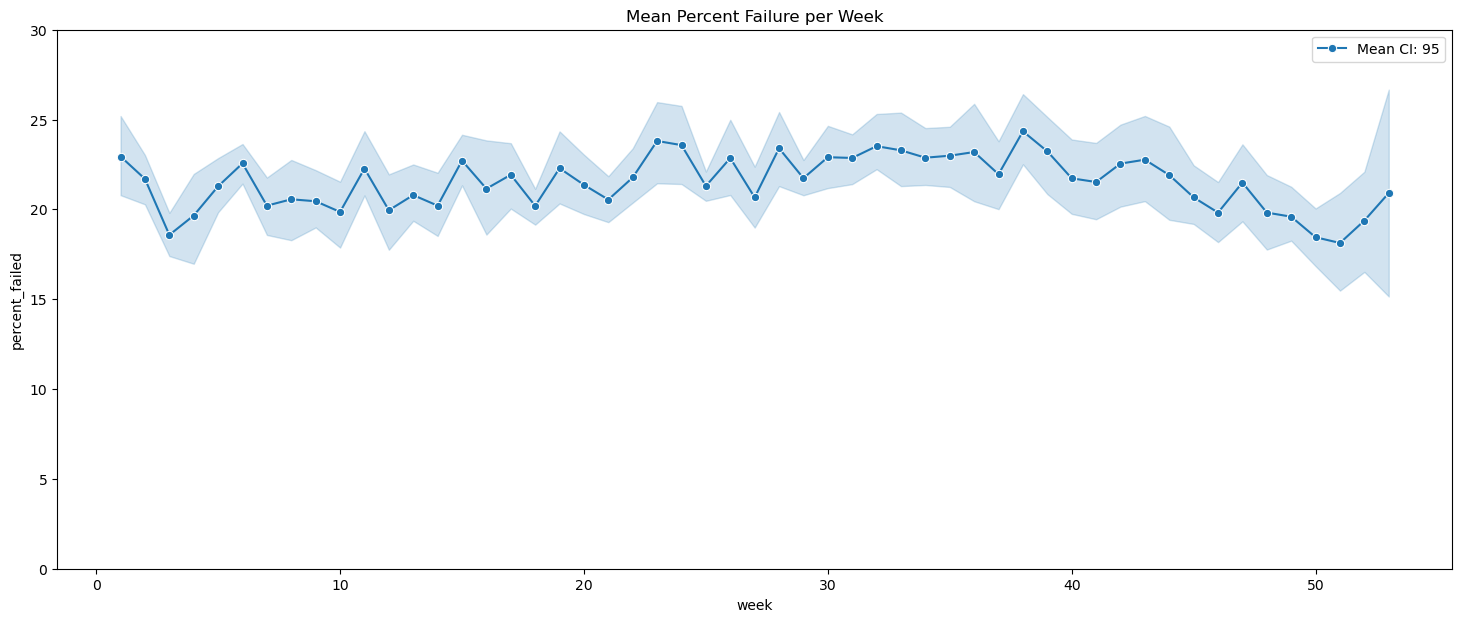

In [23]:
import seaborn as sns

failed = restaurant_df[(restaurant_df['results'] == 'Fail')].groupby(['year', 'week']).count()['inspect_id']
total = restaurant_df.groupby(['year', 'week']).count()['inspect_id']
temp = failed/total*100
temp_percent = temp.reset_index().rename(columns={'inspect_id':'percent_failed'})

fig, ax = plt.subplots(ncols=1, figsize=(18, 7))
sns.lineplot(data=temp_percent, x='week', y='percent_failed', marker='o', ci=95, ax=ax, label='Mean CI: 95')
ax.set(title='Mean Percent Failure per Week')
ax.set_ylim([0, 30])

Except for the fact that very few inspections occuring in December, the percent failed is surprisingly stable based on this average.  

The above 4 graphs indicates that Weekly and Monthly trends are fairly stable relative to each other.  **Need to show variance to understand underlying data.**  
It looks like annual effects

**Note:**  
Most business licenses are issued every 4th week.

<Axes: xlabel='date'>

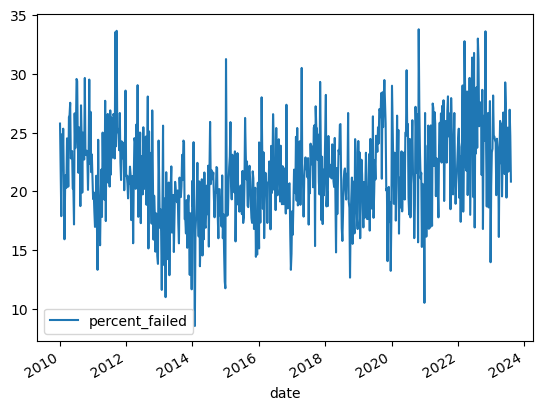

In [24]:
temp_percent['date'] = pd.to_datetime(temp_percent['year'].astype(str) + temp_percent['week'].astype(str) + '1', format='%Y%U%w')
temp_percent.plot(x='date', y='percent_failed')

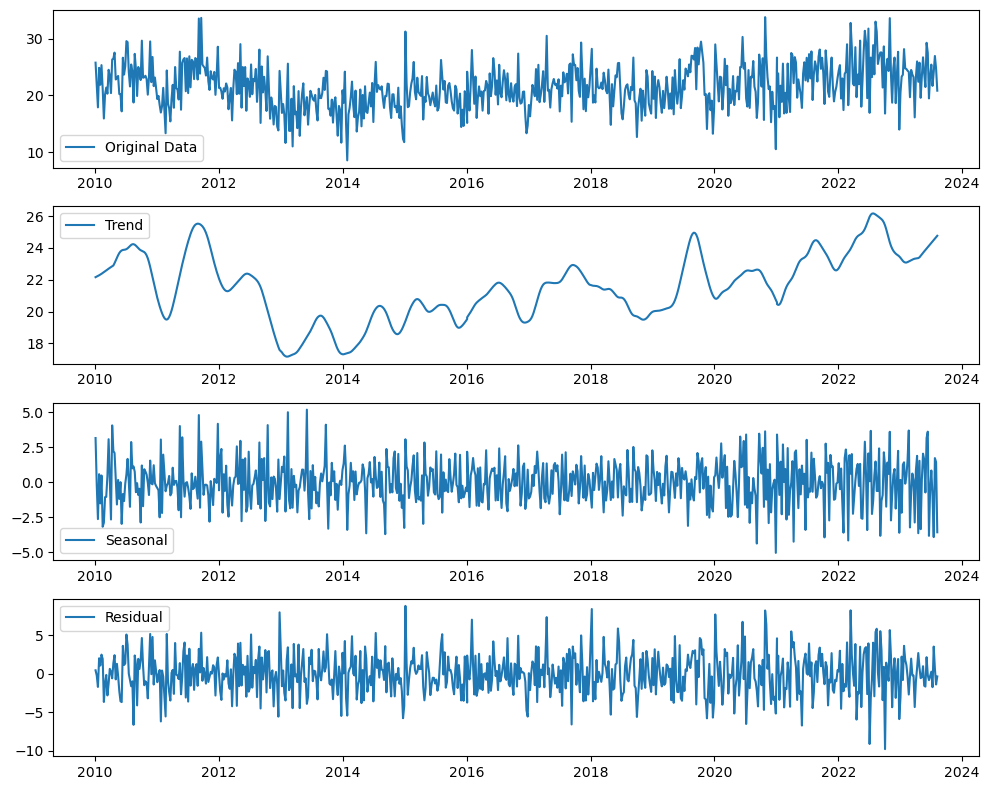

In [25]:
# Perform seasonal decomposition using STL

from statsmodels.tsa.seasonal import STL
stl = STL(temp_percent['percent_failed'], period=16)
result = stl.fit()

# Plot the decomposition components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(temp_percent['date'], temp_percent['percent_failed'], label='Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(temp_percent['date'], result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(temp_percent['date'], result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(temp_percent['date'], result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

The residual is greater than the seasonal effect and is a large amount of teh trend.  The tend is essentially a smoothed line.

### Target versus Features  



In [26]:
restaurant_df.dtypes

original_index                         int64
inspect_id                             int64
aka_name_x                            object
license_num                          float64
facility_type                         object
risk                                  object
address_x                             object
city                                  object
state                                 object
zipcode                              float64
inspect_date                  datetime64[ns]
inspect_type                          object
results                               object
violations                            object
lat                                  float64
lon                                  float64
violations_list                       object
violation_count                        int64
violation_number                      object
vl_must_comply_list                   object
vl_must_comply_count                   int64
vl_instructed_comply_list             object
vl_instruc

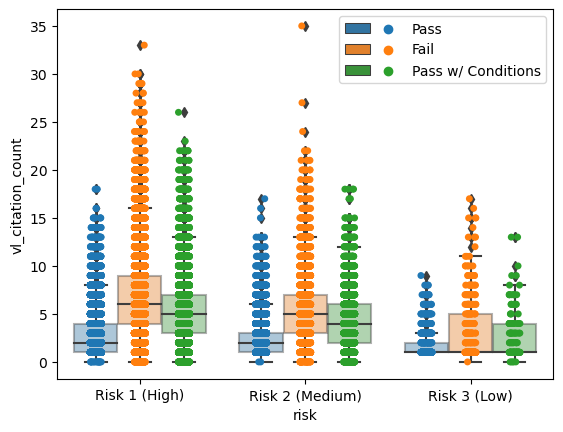

In [27]:
from matplotlib.legend_handler import HandlerTuple

ax = sns.boxplot(data=restaurant_df, x="risk", y="vl_citation_count",
                 hue='results', boxprops={'alpha': 0.4})
sns.stripplot(data=restaurant_df, x="risk", y="vl_citation_count",
              hue='results', dodge=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]),(handles[2], handles[5])],
          labels=['Pass', 'Fail', 'Pass w/ Conditions'],
          loc='upper right', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})

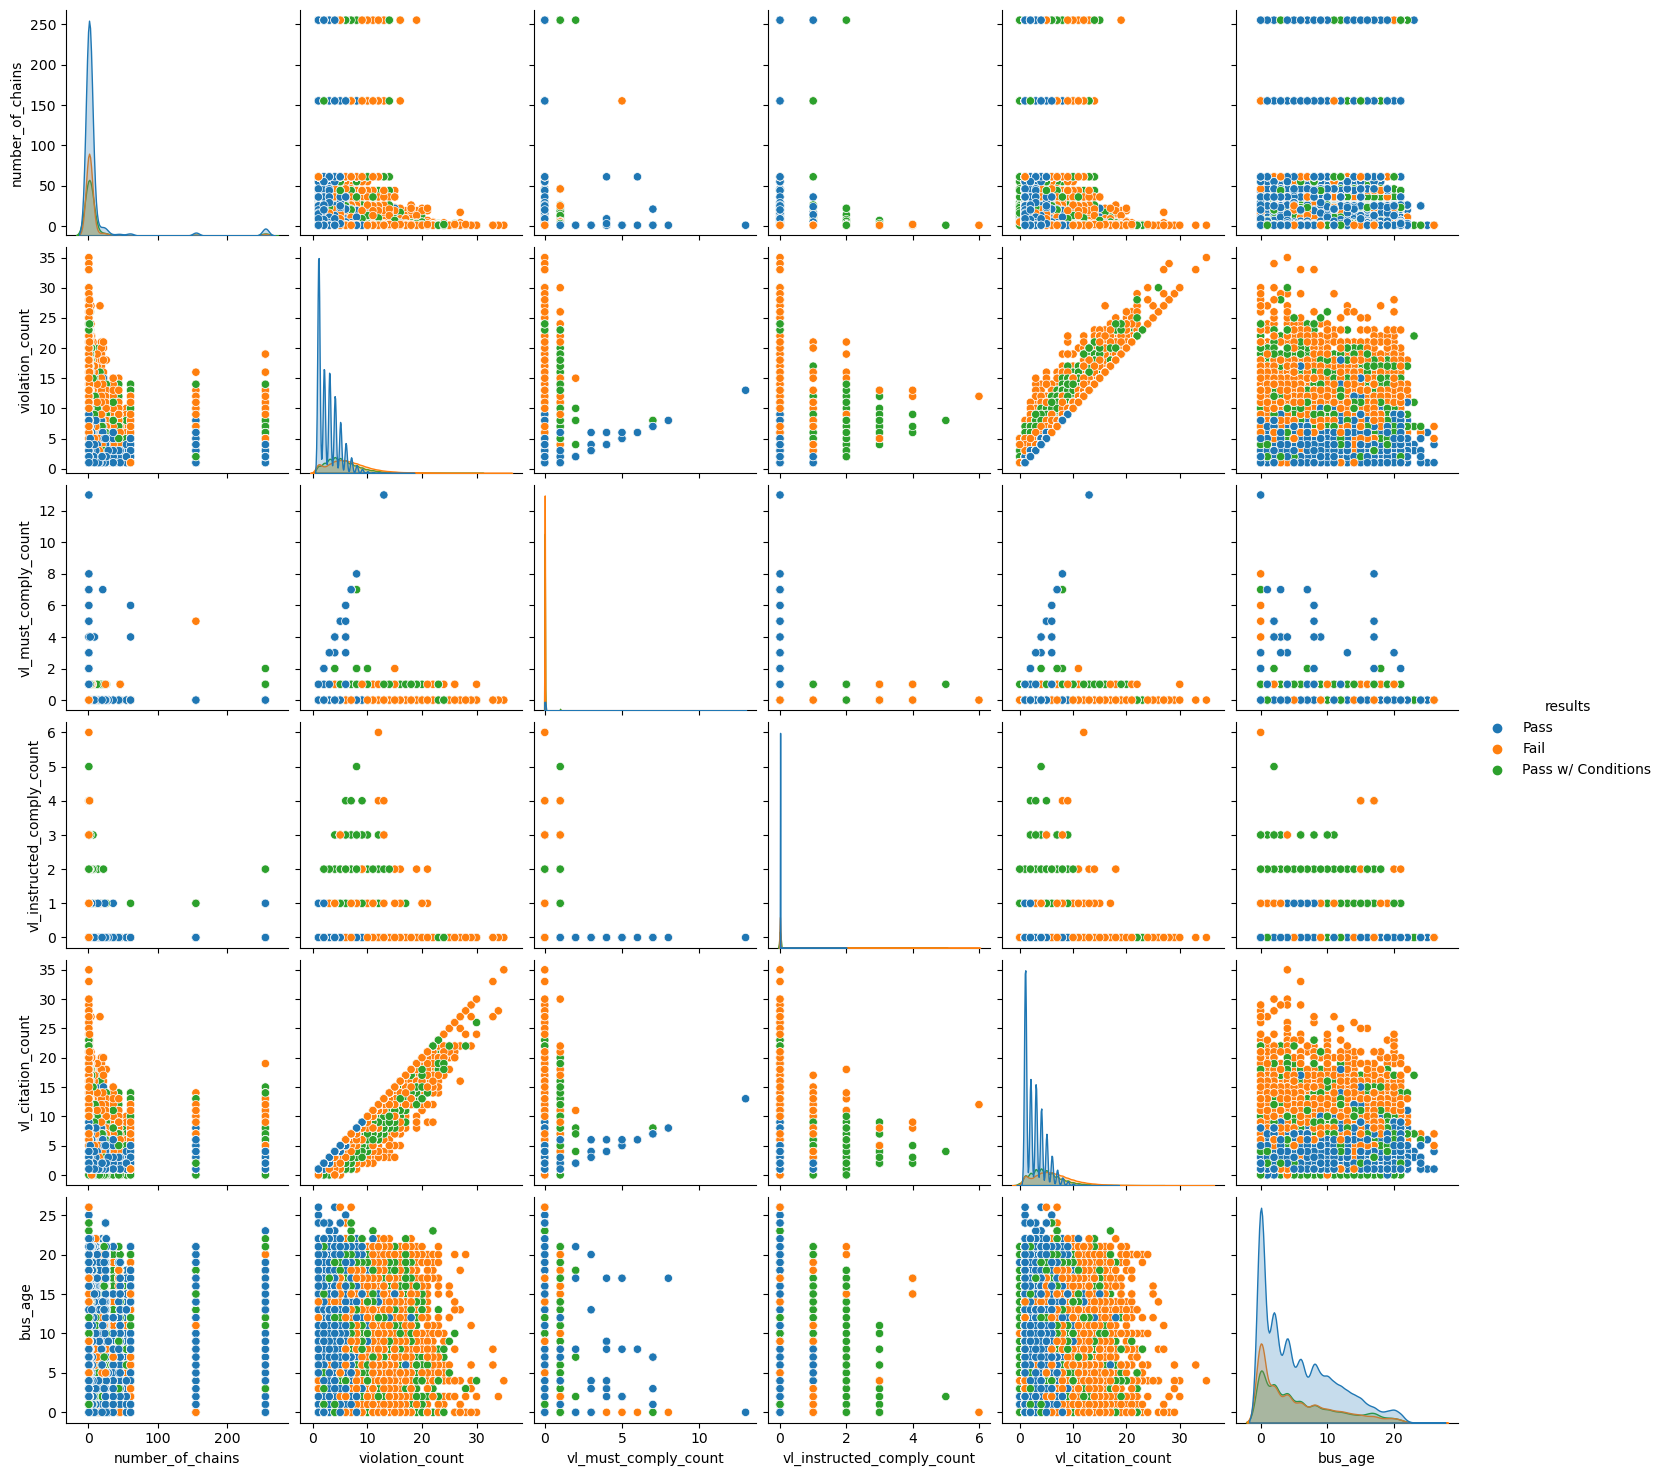

In [28]:
# numerical_columns = restaurant_df.select_dtypes(include=['number']).columns.to_list()
numerical_columns = ['number_of_chains', 'violation_count', 'vl_must_comply_count', 'vl_instructed_comply_count',
       'vl_citation_count', 'bus_age', 'results']  

sns.pairplot(restaurant_df[numerical_columns], hue='results')

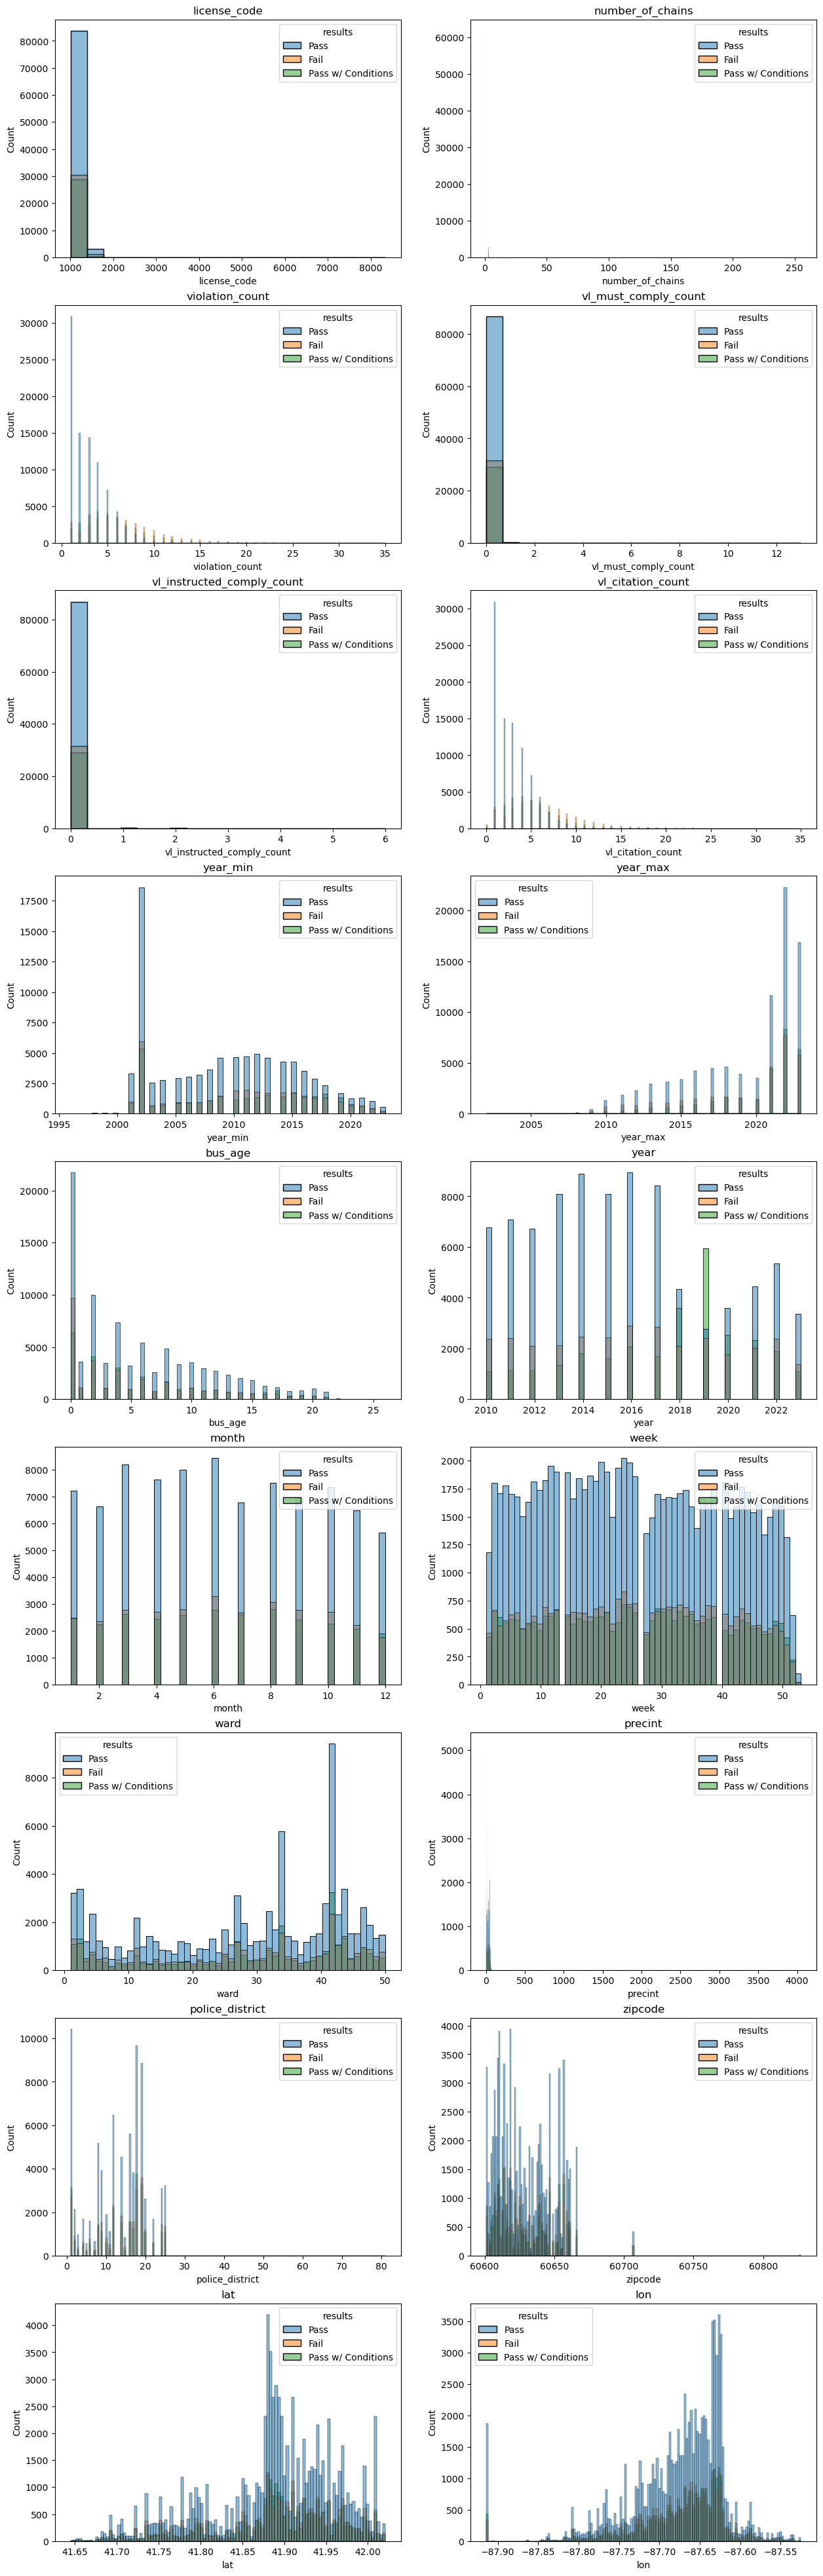

In [31]:
# convert to histogram instead of KDE
# numerical_columns = restaurant_df.select_dtypes(include=['number']).columns.to_list()
numerical_columns = ['license_code', 'number_of_chains', 'violation_count', 'vl_must_comply_count', 'vl_instructed_comply_count',
       'vl_citation_count', 'year_min', 'year_max', 'bus_age', 'year', 'month', 'week', 'ward', 'precint',
       'police_district', 'zipcode', 'lat', 'lon']

plots = len(numerical_columns)  
# fig, axes = plt.subplots(nrows=int(math.floor(plots+1)/2), ncols=2, figsize=(15,35))

fig, axes = plt.subplots(nrows=int(math.floor(plots+1)/2), ncols=2, figsize=(15,50))
for index, plot in enumerate(numerical_columns):
    sns.histplot(data=restaurant_df, x=plot, hue='results', ax=axes[int((index - index%2)/2),index%2 ])
    axes[int((index - index%2)/2),index%2 ].set_title(plot)
# sns.stripplot(data=restaurant_df, x='license_code', hue='results', dodge=True, ax=ax)

**Checks**  


** To do micro (comapny or license scale) the first need to answer these questions:  
Is the company and address the same but different license number? May need to drop one of the license numbers.   
What is the relation between previous number of inspections and success? - maybe show a category chart of 1st inspection (red is fail, blue is pass) through 10th inspection.  


1.  name  
1.  license number  
1.  result (pass/fail) \<target>
1.  business age (default start from 2010 inspection date)  
1.  number of chains / is_chain boolean 
1.  risk  
1.  ward / neighborhood
1.  license code  
1.  renew  
1.  conditional approved  
1.  business activity
1.  *number of (pass/fail) inspections during 1st, 2nd, 3rd, and 4th most recent license period
    * this can have errors so maybe use years from year_min to simplify

In [3]:
# def restaurant_type(num_chains):
#     if num_chains == 1:  
#         val = 'Single Site'
#     elif num_chains <= 5: 
#         val = '2-5 Sites'
#     elif num_chains <=10:
#         val = '6-10 Sites'
#     elif num_chains <= 25:
#         val = '11-25 Sites'
#     else:
#         val = '26+ Sites'
#     return val
        
# restaurant_df['type_of_restaurant'] = restaurant_df['number_of_chains'].apply(lambda x: restaurant_type(x))

<Axes: xlabel='results'>

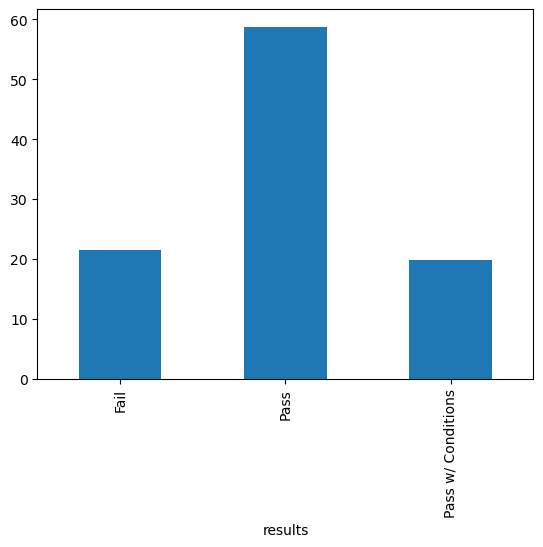

In [32]:
results_group = restaurant_df.groupby('results').count()['original_index']/len(restaurant_df)*100
results_group.plot.bar()

<Axes: xlabel='results'>

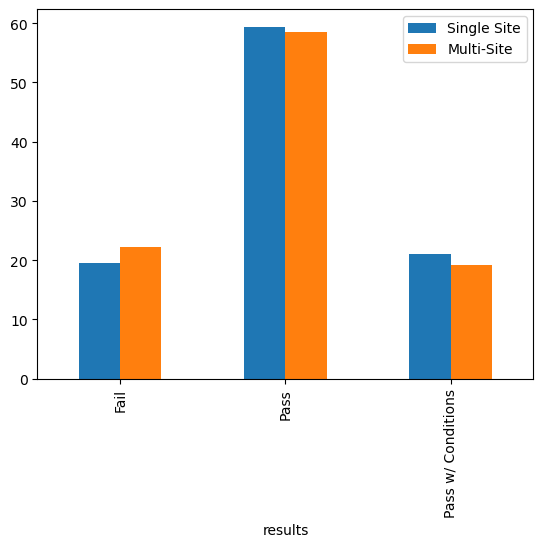

In [33]:
# 12 - bar chart comparing is chain and is not chain  
not_chain = restaurant_df[restaurant_df['type_of_restaurant'] != 'Single Site'].groupby('results').count()['original_index'] / restaurant_df[restaurant_df['type_of_restaurant'] != 'Single Site'].count()['original_index'] * 100
chain = restaurant_df[restaurant_df['type_of_restaurant'] == 'Single Site'].groupby('results').count()['original_index']/restaurant_df[restaurant_df['type_of_restaurant'] == 'Single Site'].count()['original_index'] * 100
df = pd.concat([not_chain, chain], axis=1)
df.columns = ["Single Site", "Multi-Site"]
df.plot.bar()

<Axes: xlabel='type_of_restaurant'>

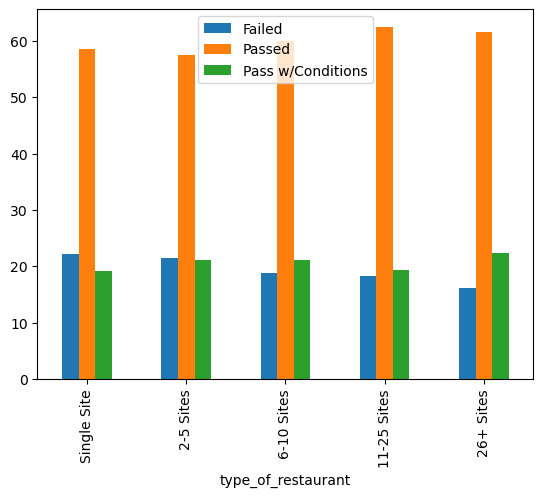

In [34]:
# 12 - bar chart comparing percent fail of chain versus not chain  
results_total = restaurant_df.groupby('type_of_restaurant').count()['original_index']
results_failed = restaurant_df[restaurant_df['results'] == 'Fail'].groupby('type_of_restaurant').count()['original_index']
results_passed = restaurant_df[restaurant_df['results'] == 'Pass'].groupby('type_of_restaurant').count()['original_index']
results_conditional_pass = restaurant_df[restaurant_df['results'] == 'Pass w/ Conditions'].groupby('type_of_restaurant').count()['original_index']
failed = results_failed/results_total * 100
passed = results_passed/results_total * 100
conditional = results_conditional_pass/results_total * 100
df = pd.concat([failed, passed, conditional], axis=1)
df.columns = ['Failed', 'Passed', 'Pass w/Conditions']
df.loc[['Single Site','2-5 Sites','6-10 Sites','11-25 Sites','26+ Sites'],:].plot.bar()

<Axes: xlabel='type_of_restaurant'>

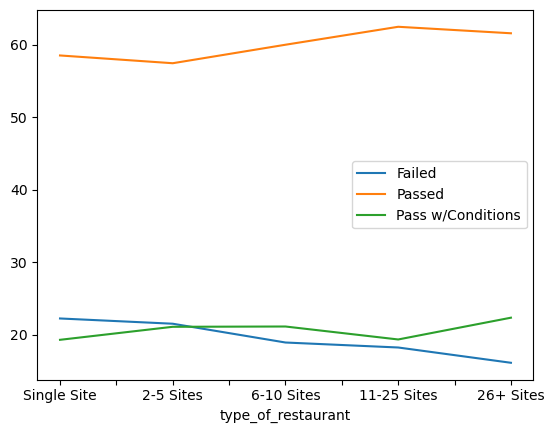

In [35]:
# 11 - line chart of franchise size versus percent fail  
df.loc[['Single Site','2-5 Sites','6-10 Sites','11-25 Sites','26+ Sites'],:].plot()


In [36]:
# restaurant_df['inspections_per_year'] = restaurant_df.groupby('license_alias').transform('count')['original_index']

# highest percent fail by license alias with more than 3 inspections and after 2022
total = restaurant_df.groupby('license_alias').count()['original_index']
failed = restaurant_df[(restaurant_df['results'] == 'Fail') & (restaurant_df['inspections_per_year']>3) & (restaurant_df['inspect_date'] > '2022-01-01')].groupby(['aka_name_x','license_alias']).count()['original_index']
percent_fail = failed/total*100
top20 = percent_fail.sort_values(ascending=False)[0:20]
temp2 = top20.index.get_level_values(1)


temp3 = restaurant_df[restaurant_df['license_alias'].isin(temp2)].groupby(['aka_name_x','license_alias']).agg({'license_alias': 'count', 'inspect_date':'max'})
temp3.columns = ['number_of_inspections', 'last_inspection_date']
df = pd.concat([temp3, top20], axis=1)
df.columns=['number_of_inspections', 'last_inspection_date', 'percent_fail']
df.sort_values(by='percent_fail', ascending=False)


,,number_of_inspections,last_inspection_date,percent_fail
aka_name_x,license_alias,,,
CAFE COCO LATTE LLC,2328,4,2023-05-31,75.000000
TACOS EL MERCADITO LLC,15795,4,2023-01-11,75.000000
SUPER JJ CHICKEN FISH AND RIBS,15403,8,2023-04-20,62.500000
MOONBOWLS,10874,5,2023-06-02,60.000000
I - 94 RIBS & GRILL,7395,5,2023-06-12,60.000000
JACK'S,7713,5,2023-06-15,60.000000
KONG DOG,8654,5,2023-01-30,60.000000
KYOKU SUSHI,8722,5,2022-05-18,60.000000
LA MICHOACANA Y MAS,9022,5,2023-06-07,60.000000


<Axes: xlabel='year,month'>

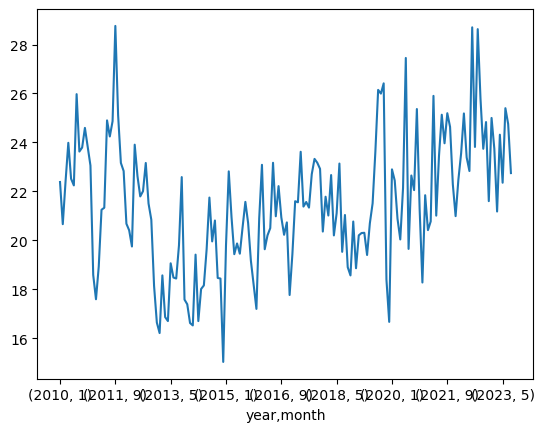

In [37]:
# 10 - line chart percent fail over time
results_total = restaurant_df.groupby(['year','month']).count()['original_index']
results_failed = restaurant_df[restaurant_df['results'] == 'Fail'].groupby(['year','month']).count()['original_index']
failed = results_failed/results_total * 100
failed.plot()

<Axes: xlabel='year'>

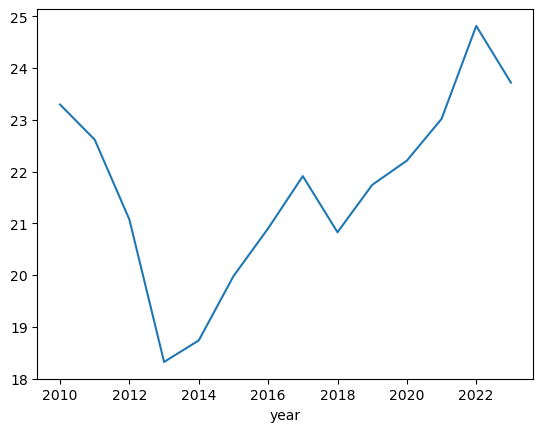

In [38]:
# 10 - line chart percent fail over time
results_total = restaurant_df.groupby(['year']).count()['original_index']
results_failed = restaurant_df[restaurant_df['results'] == 'Fail'].groupby(['year']).count()['original_index']
failed = results_failed/results_total * 100
failed.plot()

<Axes: xlabel='risk'>

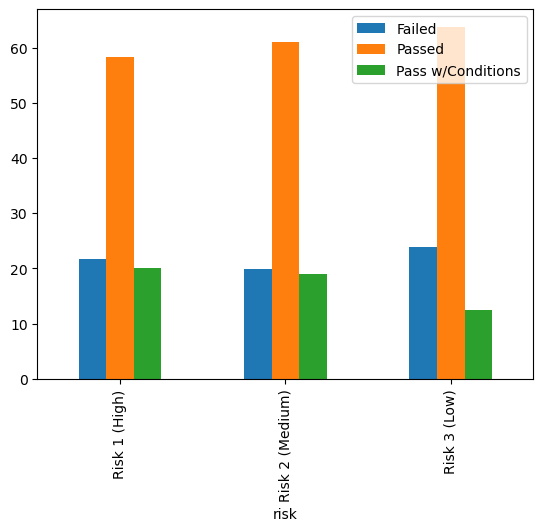

In [39]:
# 13 - bar chart comparing 3 risk categories and percent fail  
results_total = restaurant_df.groupby('risk').count()['original_index']
results_failed = restaurant_df[restaurant_df['results'] == 'Fail'].groupby('risk').count()['original_index']
results_passed = restaurant_df[restaurant_df['results'] == 'Pass'].groupby('risk').count()['original_index']
results_conditional_pass = restaurant_df[restaurant_df['results'] == 'Pass w/ Conditions'].groupby('risk').count()['original_index']
failed = results_failed/results_total * 100
passed = results_passed/results_total * 100
conditional = results_conditional_pass/results_total * 100
df = pd.concat([failed, passed, conditional], axis=1)
df.columns = ['Failed', 'Passed', 'Pass w/Conditions']
df.plot.bar()

<Axes: xlabel='ward'>

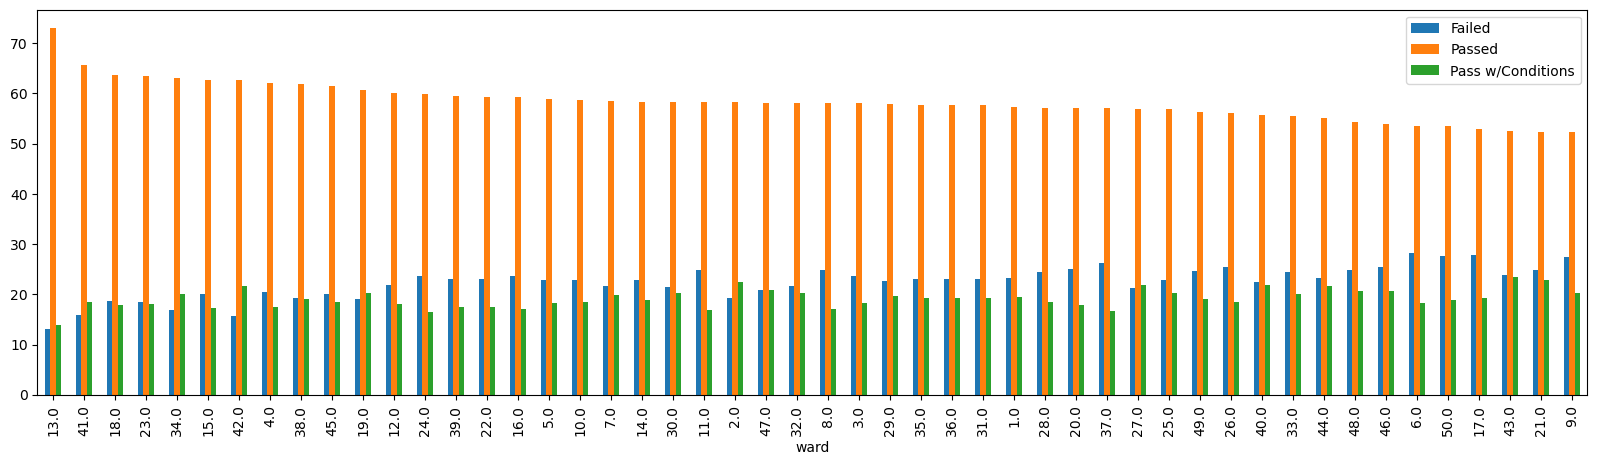

In [40]:
# 14 - bar chart of wards and percent fail  
# 14 - Does the location make a difference?  
# Ward 13 and Ward 9 are significantly different

results_total = restaurant_df.groupby('ward').count()['original_index']
results_failed = restaurant_df[restaurant_df['results'] == 'Fail'].groupby('ward').count()['original_index']
results_passed = restaurant_df[restaurant_df['results'] == 'Pass'].groupby('ward').count()['original_index']
results_conditional_pass = restaurant_df[restaurant_df['results'] == 'Pass w/ Conditions'].groupby('ward').count()['original_index']
failed = results_failed/results_total * 100
passed = results_passed/results_total * 100
conditional = results_conditional_pass/results_total * 100
df = pd.concat([failed, passed, conditional], axis=1)
df.columns = ['Failed', 'Passed', 'Pass w/Conditions']
df.sort_values(by='Passed', ascending=False).plot.bar(figsize=(20,5))

<Axes: xlabel='address_x,license_alias'>

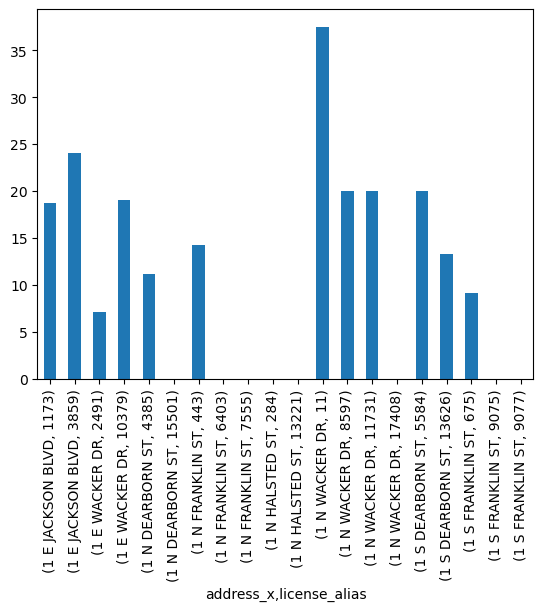

In [41]:
# 14 (other) - Do certain addresses with multiple companies have a history of failing? 
# Need to make a more practical graphic 
temp = restaurant_df.groupby(['address_x','license_alias']).count()['original_index'].reset_index()
license_alias_no = temp[temp.duplicated(subset='address_x',keep=False)]['license_alias']
df = restaurant_df[restaurant_df['license_alias'].isin(license_alias_no)]  
total = df[(restaurant_df['inspections_per_year']>3)].groupby(['address_x', 'license_alias']).count()['original_index']  
failed = df[(df['results'] == 'Fail') & (restaurant_df['inspections_per_year']>3)].groupby(['address_x', 'license_alias']).count()['original_index']  
percent = failed/total * 100
percent.iloc[0:20].plot.bar()  

<Axes: xlabel='license_code'>

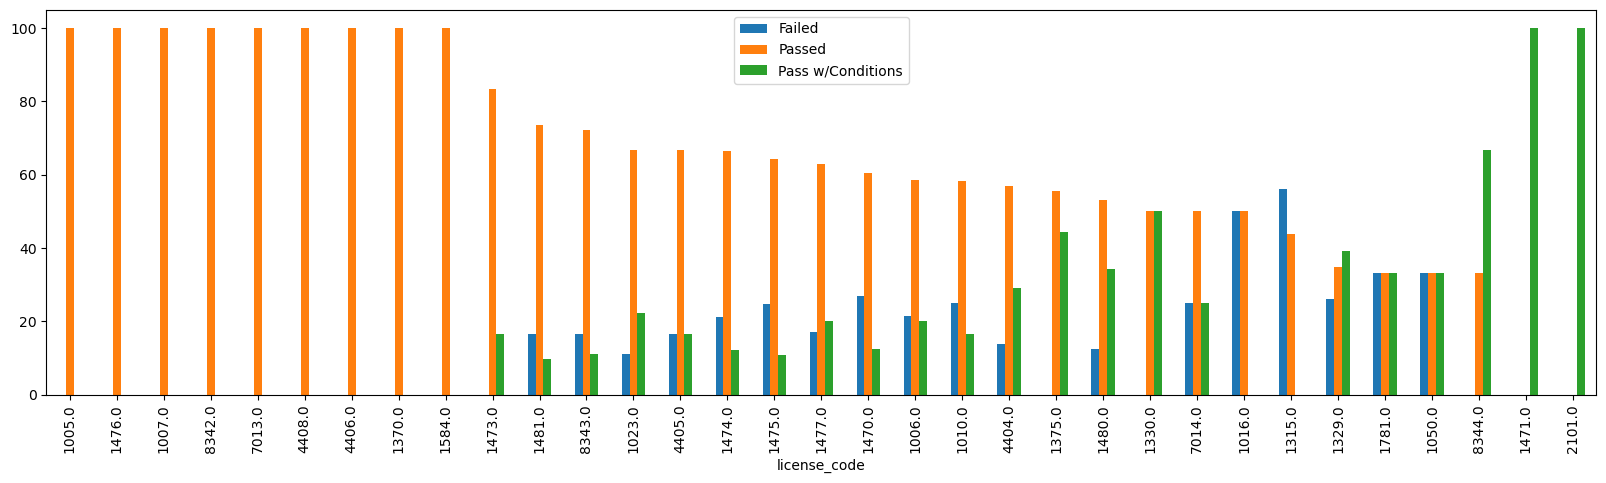

In [43]:
# 15 - license code
results_total = restaurant_df.groupby('license_code').count()['original_index']
results_failed = restaurant_df[restaurant_df['results'] == 'Fail'].groupby('license_code').count()['original_index']
results_passed = restaurant_df[restaurant_df['results'] == 'Pass'].groupby('license_code').count()['original_index']
results_conditional_pass = restaurant_df[restaurant_df['results'] == 'Pass w/ Conditions'].groupby('license_code').count()['original_index']
failed = results_failed/results_total * 100
passed = results_passed/results_total * 100
conditional = results_conditional_pass/results_total * 100
df = pd.concat([failed, passed, conditional], axis=1)
df.columns = ['Failed', 'Passed', 'Pass w/Conditions']
df.sort_values(by='Passed', ascending=False).plot.bar(figsize=(20,5))

<Axes: xlabel='application_type'>

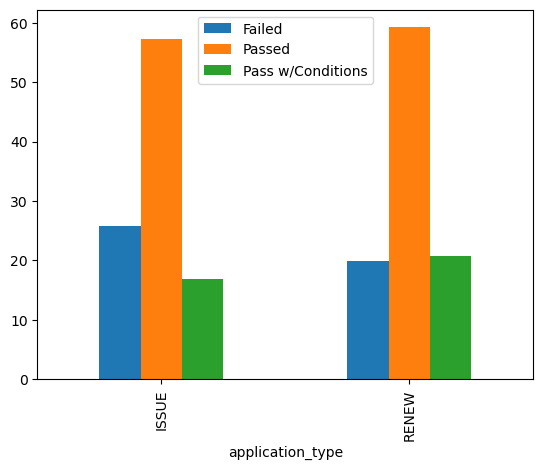

In [44]:
# 16 - bar chart of renew and percent fail  
results_total = restaurant_df.groupby('application_type').count()['original_index']
results_failed = restaurant_df[restaurant_df['results'] == 'Fail'].groupby('application_type').count()['original_index']
results_passed = restaurant_df[restaurant_df['results'] == 'Pass'].groupby('application_type').count()['original_index']
results_conditional_pass = restaurant_df[restaurant_df['results'] == 'Pass w/ Conditions'].groupby('application_type').count()['original_index']
failed = results_failed/results_total * 100
passed = results_passed/results_total * 100
conditional = results_conditional_pass/results_total * 100
df = pd.concat([failed, passed, conditional], axis=1)
df.columns = ['Failed', 'Passed', 'Pass w/Conditions']
df.plot.bar()


<Axes: xlabel='conditional_approval'>

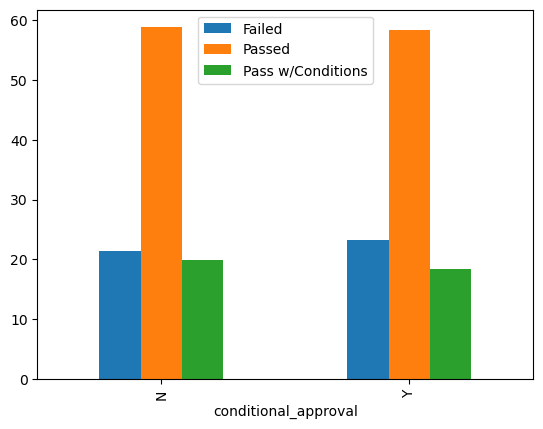

In [45]:
# 17 - bar chart of condiational approval  boolean and percent fail  
results_total = restaurant_df.groupby('conditional_approval').count()['original_index']
results_failed = restaurant_df[restaurant_df['results'] == 'Fail'].groupby('conditional_approval').count()['original_index']
results_passed = restaurant_df[restaurant_df['results'] == 'Pass'].groupby('conditional_approval').count()['original_index']
results_conditional_pass = restaurant_df[restaurant_df['results'] == 'Pass w/ Conditions'].groupby('conditional_approval').count()['original_index']
failed = results_failed/results_total * 100
passed = results_passed/results_total * 100
conditional = results_conditional_pass/results_total * 100
df = pd.concat([failed, passed, conditional], axis=1)
df.columns = ['Failed', 'Passed', 'Pass w/Conditions']
df.plot.bar()

<Axes: xlabel='license_alias'>

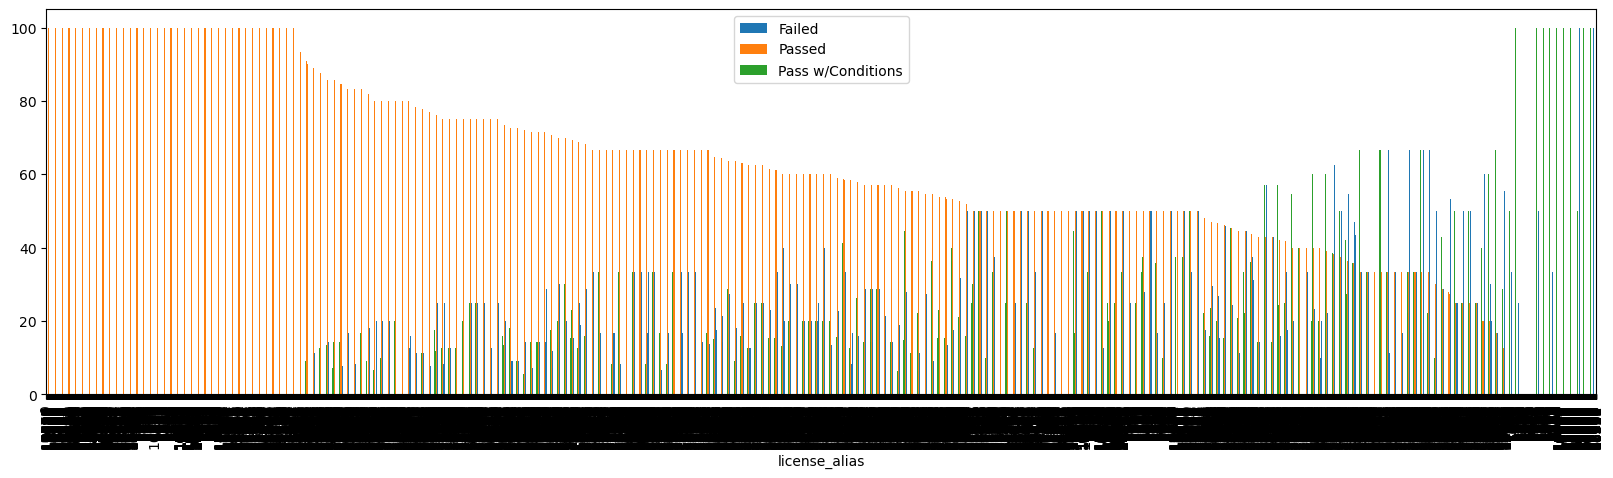

In [46]:
# 18 - bar chart of total count fails per business and bar chart of percent fail per business  
results_total = restaurant_df.groupby('license_alias').count()['original_index']
results_failed = restaurant_df[restaurant_df['results'] == 'Fail'].groupby('license_alias').count()['original_index']
results_passed = restaurant_df[restaurant_df['results'] == 'Pass'].groupby('license_alias').count()['original_index']
results_conditional_pass = restaurant_df[restaurant_df['results'] == 'Pass w/ Conditions'].groupby('license_alias').count()['original_index']
failed = results_failed/results_total * 100
passed = results_passed/results_total * 100
conditional = results_conditional_pass/results_total * 100
df = pd.concat([failed, passed, conditional], axis=1)
df.columns = ['Failed', 'Passed', 'Pass w/Conditions']
df.sort_values(by='Passed', ascending=False).plot.bar(figsize=(20,5))

In [ ]:
# 19 - active or inactive business (based on business license experation)
# similar to above